In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-42a05s1s
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-42a05s1s
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-38xsevs3/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmp5stvw767".


In [49]:
!nvidia-smi

Mon Jan 29 08:17:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
%%cuda 
#include <stdio.h>
#include <time.h>
#include <stdlib.h>
#include <curand.h>
#include <curand_kernel.h>

inline cudaError_t cudaSafeRun(cudaError_t err, const char* msg){
    if(err!=cudaSuccess){ 
        fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    }
    return err;
} 

__global__ void random_device(int *randArray, int size){
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    
    //random numbers
    if(idx<size){
        curandState state;
        curand_init(clock64(),idx,0,&state);
        float myrandf = curand_uniform(&state); 
        //fixing range of random numbers
        myrandf *= (1000 - 1 + 0.99999);
        myrandf += 1;
        int myrand = (int)truncf(myrandf);
        randArray[idx] = myrand;
    }
}



void random_host(int array[], int s){
    srand(time(NULL));
    for(int i=0;i<s;i++){
        array[i] = rand();
    }
}

int main() { 
    
    //1 million random elements
    int size = 1000000;
    int h_random[size];
    
    //initializing events to calculate time on host
    cudaEvent_t h_start,h_stop;
    cudaSafeRun(cudaEventCreate(&h_start),"Event Creation");
    cudaSafeRun(cudaEventCreate(&h_stop),"Event Creation");
    
    //calling host function wrapped in events
    cudaSafeRun(cudaEventRecord(h_start),"Event Recording Start");
    random_host(h_random,size);
    cudaSafeRun(cudaEventRecord(h_stop),"Event Recording Stop");
    cudaSafeRun(cudaEventSynchronize(h_stop),"Event Recording Synchronize");
    
    //calculating time
    float ht = 0;
    cudaSafeRun(cudaEventElapsedTime(&ht,h_start,h_stop),"Time Calculation");
    printf("Total time to generate random numbers on CPU: %f msecs\n", ht);
    
    //array to generate random numbers on GPU and copy back to CPU.
    int* randArray = 0;
    int* h_randArray = 0;
    
    //allocating memory
    h_randArray = (int*)malloc(size*sizeof(int));
    cudaMalloc((void**)&randArray,size*sizeof(int));
    
    //initializing events to record GPUs time
    cudaEvent_t d_start,d_stop;
    cudaSafeRun(cudaEventCreate(&d_start),"Event Creation");
    cudaSafeRun(cudaEventCreate(&d_stop),"Event Creation");
    
    //GPU random number generation wrapped in events
    cudaSafeRun(cudaEventRecord(d_start),"Event Recording Start");
    random_device<<<1000,1000>>>(randArray,size);
    cudaSafeRun(cudaDeviceSynchronize(),"Synchronization");
    cudaSafeRun(cudaEventRecord(d_stop),"Event Recording Stop");
    cudaSafeRun(cudaEventSynchronize(d_stop),"Event Synchronization");
    
    //calculating time for GPU
    float dt = 0;
    cudaSafeRun(cudaEventElapsedTime(&dt,d_start,d_stop),"Time Calculation");
    printf("Total time to generate random numbers on GPU: %f msecs\n", dt);
    
    //initializing event variables to calculate time between copying
    cudaEvent_t c_start,c_stop;
    cudaSafeRun(cudaEventCreate(&c_start),"Event Creation");
    cudaSafeRun(cudaEventCreate(&c_stop),"Event Creation");
    
    //call wrapped in event
    cudaSafeRun(cudaEventRecord(c_start),"Event Recording Start");
    cudaSafeRun(cudaMemcpy(h_randArray,randArray,size*sizeof(int),cudaMemcpyDeviceToHost),"Memory Copy");
    cudaSafeRun(cudaEventRecord(c_stop),"Event Recording Stop");
    cudaSafeRun(cudaEventSynchronize(c_stop),"Event Synchronization");
    
    //calculating time
    float ct = 0;
    cudaSafeRun(cudaEventElapsedTime(&ct,c_start,c_stop),"Time Calculation");
    printf("Total time to copy values from GPU to CPU: %f msecs\n", ct);
    
    printf("Testing first 10 random numbers\n");
    for(int i=0;i<10;i++){
        printf("%3d: %3d\n",i,h_randArray[i]);
    }
    
    cudaFree(randArray);
    free(h_randArray);

	cudaDeviceReset();
	return 0;
}

Total time to generate random numbers on CPU: 23.403360 msecs
Total time to generate random numbers on GPU: 325.809753 msecs
Total time to copy values from GPU to CPU: 3.614816 msecs
Testing first 10 random numbers
  0: 928
  1: 882
  2:  26
  3: 394
  4:  45
  5: 472
  6: 565
  7: 785
  8: 221
  9: 478



Q2:

In [37]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

inline cudaError_t cudaSafeRun(cudaError_t err, const char* msg){
    if(err!=cudaSuccess){ 
        fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    }
    return err;
} 

//Kernel function
__global__ void d_sum(int *a, int *c, const int N) {
    //allocating shared memory
    __shared__ int local_sum[512];
    local_sum[threadIdx.x] = 0;

    //storing array addition on local shared memory
    for (int i = threadIdx.x; i < N; i += blockDim.x) {
        local_sum[threadIdx.x] += *(a+i);
    }

    __syncthreads();

    if(blockDim.x<=32){
        //unrolling loop to improve performance of 32 configuration
        if(threadIdx.x < 32){
            local_sum[threadIdx.x] += local_sum[threadIdx.x + 32];
            local_sum[threadIdx.x] += local_sum[threadIdx.x + 16];
            local_sum[threadIdx.x] += local_sum[threadIdx.x + 8];
            local_sum[threadIdx.x] += local_sum[threadIdx.x + 4];
            local_sum[threadIdx.x] += local_sum[threadIdx.x + 2];
            local_sum[threadIdx.x] += local_sum[threadIdx.x + 1];
        }
        __syncthreads();
    }else{
        for (int s = blockDim.x / 2; s > 32; s >>= 1) {
            if (threadIdx.x < s) {
                local_sum[threadIdx.x] += local_sum[threadIdx.x + s];
            }
            __syncthreads();
        }
    }

    //assigning output
    *c = (threadIdx.x == 0) ? local_sum[0] : *c;

}

int h_sum(int* a,const int N){
    int result = 0;
    for(int i=0;i<N;i++){
        result+=a[i];
    }
    return result;
}

int main() {
    
    //file to store values to connect data with python matplotlib
    FILE *file = fopen("time_data.txt","w");
    if(file==NULL){
        printf("Cannot open file\n");
        return;
    }
    
    //different configs
    const int N[] = {1000,10000,100000,1000000};
    const int data_size = 4;
    const int configs[] = {32,64,128,256,512};
    const int config_size = 5;
    
    for (int ii=0;ii<data_size;ii++){
        printf("Data Size: %d\n",N[ii]);
        // allocate memory on host
        int *h_arr = (int *)malloc(N[ii] * sizeof(int));

        // Populate array with random values
        for (int j = 0; j < N[ii]; ++j) {
            h_arr[j] = 1;
        }
        
        int *d_arr;
        cudaMalloc((void **)&d_arr, N[ii] * sizeof(int));
        
        // Copy array from host to device
        cudaMemcpy(d_arr, h_arr, N[ii] * sizeof(int), cudaMemcpyHostToDevice);
        
        cudaEvent_t h_start,h_stop;
        cudaEventCreate(&h_start);
        cudaEventCreate(&h_stop);
        
        cudaEventRecord(h_start);
        // calculation on host
        int cpu_result = h_sum(h_arr,N[ii]);
        cudaEventRecord(h_stop);
        cudaEventSynchronize(h_stop);
        
        float ht=0;
        cudaEventElapsedTime(&ht,h_start,h_stop);
        
        printf("CPU Result: %d in %f msecs\n", cpu_result,ht);

        for (int i=0;i<config_size;i++){
            // Allocate memory on device
            int *d_result;
            cudaMalloc((void **)&d_result, sizeof(int));

            // calculate on device
            
            const int threadsPerBlock = configs[i];
            int blocks = ceilf(N[ii]/threadsPerBlock + 1);
            
            cudaEvent_t d_start,d_stop;
            cudaEventCreate(&d_start);
            cudaEventCreate(&d_stop);
            
            cudaEventRecord(d_start);
            d_sum<<<blocks, threadsPerBlock>>>(d_arr, d_result, N[ii]);
            //custom_sum_kernel_alternative<<<blocks, threadsPerBlock>>>(d_arr,d_result,N[ii]);
            cudaEventRecord(d_stop);
            cudaSafeRun(cudaDeviceSynchronize(),"Synchronize");
            cudaEventSynchronize(d_stop);
            
            float dt=0;
            cudaEventElapsedTime(&dt,d_start,d_stop);

            // Copy result from device to host
            int h_result;
            cudaMemcpy(&h_result, d_result, sizeof(int), cudaMemcpyDeviceToHost);

            // Output result
            printf("GPU Result: %d in %f msecs (%d threads ber block)\n", h_result,dt,configs[i]);
            
            cudaFree(d_result);
            
            fprintf(file,"%f\t%f\n",ht,dt);
        }
        cudaFree(d_arr);
        free(h_arr);
        cudaDeviceReset();
    }
    fclose(file);
    return 0;
}

Data Size: 1000
CPU Result: 1000 in 0.004096 msecs
GPU Result: 190 in 0.194400 msecs (32 threads ber block)
GPU Result: 16 in 0.016800 msecs (64 threads ber block)
GPU Result: 16 in 0.011520 msecs (128 threads ber block)
GPU Result: 16 in 0.010016 msecs (256 threads ber block)
GPU Result: 16 in 0.013408 msecs (512 threads ber block)
Data Size: 10000
CPU Result: 10000 in 0.030496 msecs
GPU Result: 1877 in 0.316000 msecs (32 threads ber block)
GPU Result: 157 in 0.072032 msecs (64 threads ber block)
GPU Result: 157 in 0.038688 msecs (128 threads ber block)
GPU Result: 157 in 0.028992 msecs (256 threads ber block)
GPU Result: 157 in 0.017760 msecs (512 threads ber block)
Data Size: 100000
CPU Result: 100000 in 0.259328 msecs
GPU Result: 18750 in 6.131360 msecs (32 threads ber block)
GPU Result: 1563 in 1.754240 msecs (64 threads ber block)
GPU Result: 1563 in 0.879776 msecs (128 threads ber block)
GPU Result: 1563 in 0.447456 msecs (256 threads ber block)
GPU Result: 1563 in 0.234592 msec

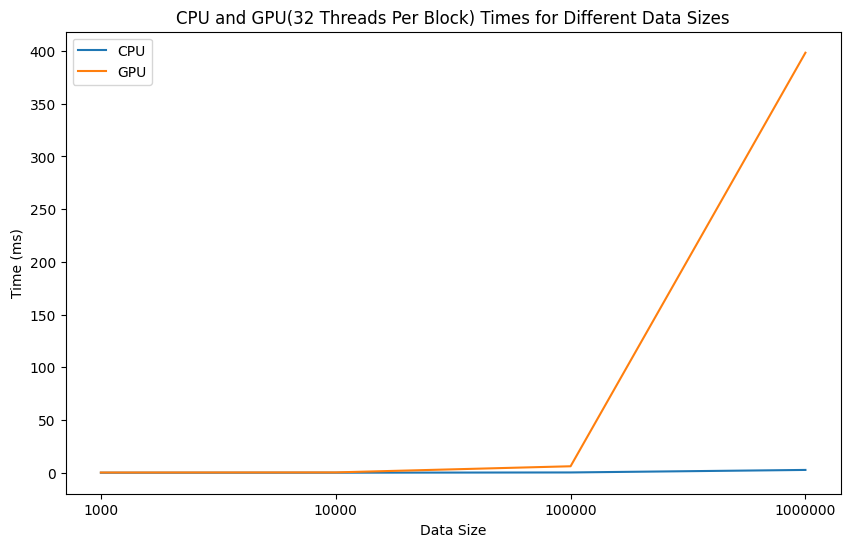

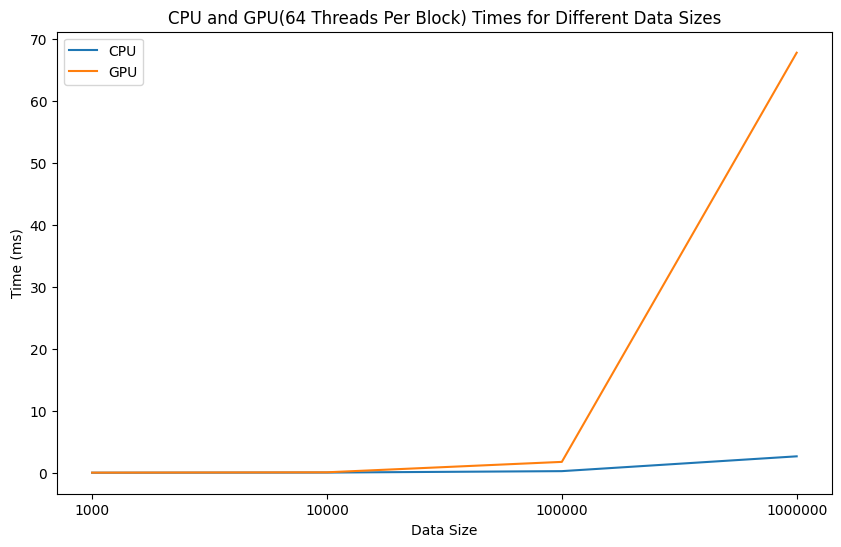

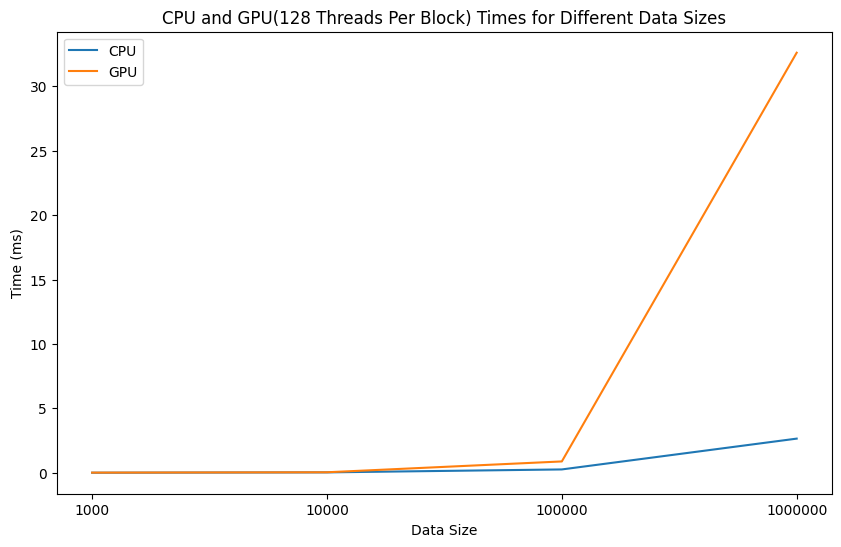

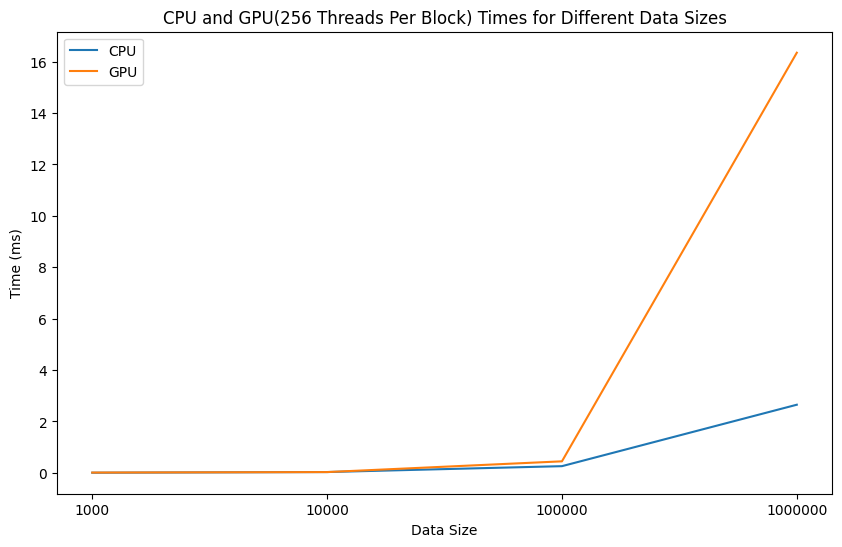

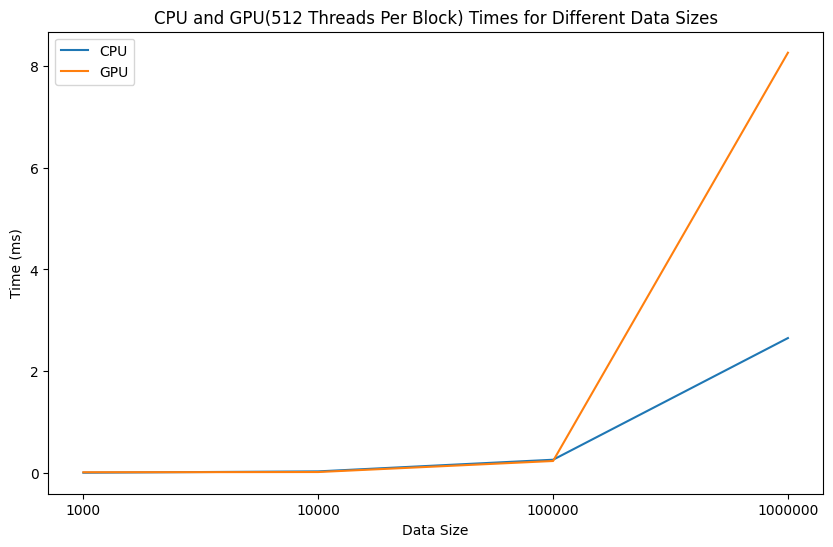

In [38]:
import matplotlib.pyplot as plt

with open('time_data.txt', 'r') as file:
    lines = file.readlines()

cpu_times = []
gpu_times = []

for line in lines:
    cpu_time, gpu_time = map(float, line.strip().split())
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

configs = [32,64,128,256,512]
    
configurations_cpu = [cpu_times[i:i+len(configs)] for i in range(0, len(cpu_times), len(configs))]
configurations_gpu = [gpu_times[i:i+len(configs)] for i in range(0, len(gpu_times), len(configs))]
config_names = [f'{i} threads per block' for i in configs]

data_size_labels = ['1000', '10000', '100000','1000000']

config_fixed_data = [i[2] for i in configurations_cpu]

a = ['CPU','GPU']

for i in range(len(configs)):
    cpu_data = [s[i] for s in configurations_cpu]
    gpu_data = [s[i] for s in configurations_gpu]
    configurations_combined = [cpu_data,gpu_data]
    plt.figure(figsize=(10, 6))
    for item, config in enumerate(configurations_combined):
        plt.plot(config, label=a[item])

    plt.xticks(range(len(data_size_labels)), data_size_labels)

    plt.xlabel('Data Size')
    plt.ylabel('Time (ms)')
    plt.title(f'CPU and GPU({configs[i]} Threads Per Block) Times for Different Data Sizes')
    plt.legend()
    plt.show()

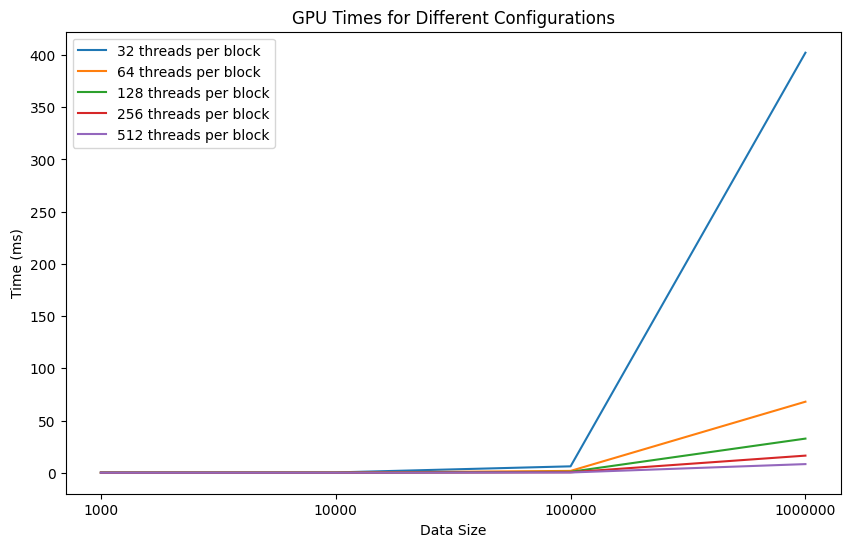

In [24]:
data_gpu = []
for k in range(len(config_names)):
    x = []
    for l in range(len(data_size_labels)):
        x.append(configurations_gpu[l][k])
    data_gpu.append(x)

plt.figure(figsize=(10, 6))
for i, data_size in enumerate(data_gpu):
    plt.plot(data_size,label=config_names[i])
    
plt.xticks(range(len(data_size_labels)), data_size_labels)

plt.xlabel('Data Size')
plt.ylabel('Time (ms)')
plt.title('GPU Times for Different Configurations')
plt.legend()
plt.show()

The following references were used. Brown University's lecture slides were used to write random number function code for GPU. Dr Mobeen Movania's repository code was used for CUDA Error handling function. AI assistance was used to write code to generate plots.

References:
1. Week 11 Lecture Slides, Cuda Part 2, Brown University Computer Science, https://cs.brown.edu/courses/cs195v/lecture/week11.pdf.
2. Cuda Spring_2024 Github Repository, Mobeen Movania, https://github.com/mmmovania/CUDA_Spring_2024
3. https://chat.openai.com/share/94535829-ccfd-4735-95dc-821b5b8e55fd9

<a href="https://colab.research.google.com/github/mmmovania/CUDA_Spring2023/blob/main/Week3/CalculateSumOnGPU_BlockIdx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>